In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import default_timer as timer

import importlib
import utils
import networks

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

# change the default figure size
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 8})

# # Enable widget mode for interactive 3D plotting in Jupyter Lab
# %matplotlib widget

True
cuda


In [3]:
# model parameters
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# model parameters
lossFunction = nn.MSELoss()
sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1]
lr = 3e-5
activation = 'relu'

# training parameters
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

n_epochs = 10000
pinn_loss_weights = [1, 1, 1]
ipinn_loss_weight = [1, 1, 1]

# Train

In [5]:
# awipinn, min_model, mse_loss_hist, pde_loss_hist, bc_loss_hist, data_loss_hist, loss_weights_hist = utils.network_training(
#         K, r, sigma, T, S_range[-1], S_range, t_range, gs, samples['bc'], samples['fc'], samples['pde'], RNG_key=123,
#         device=device, net='ipinn', sizes=sizes, activation=activation, learning_rate=lr, aw_learning_rate=0.001, n_epochs=n_epochs, lossFunction=lossFunction, dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0, loss_weights=ipinn_loss_weight, adaptive_weight=True, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
#         )

# torch.save(min_model, "nn.pth")  # Save the model's state dictionary

[Training procedure]: 100%|##########| 10000/10000 [04:04<00:00, 40.87it/s]


# Compare Predict and Exact

In [17]:
model = networks.ImprovedNeuralNetwork(sizes, 'relu', 0, 0.1, 10.0)
model.to(device)
model.load_state_dict(torch.load('nn.pth'))
model.eval()
prediction = model(X_test_tensor)
print(lossFunction(prediction, y_test_tensor).item())

# Define the range of stock prices and time periods
stock_prices = np.linspace(0, int(5*K), 50)  # Example range of stock prices
time_periods = np.linspace(0, 1, 50)  # Example range of time periods

# Create a grid of stock prices and time periods
stock_grid, time_grid = np.meshgrid(stock_prices, time_periods)

# Initialize an empty grid for option prices
option_prices = np.zeros_like(stock_grid)

# Populate the option price grid by making predictions
for i in range(stock_grid.shape[0]):
    for j in range(stock_grid.shape[1]):
        stock_price = stock_grid[i, j]
        time_period = time_grid[i, j]
        # Prepare the input data (e.g., convert to PyTorch tensor if needed)
        input_data = torch.tensor([[time_period, stock_price]], dtype=torch.float32).to(device)
        
        # Make a prediction using the loaded model
        prediction = model(input_data)
        
        # Extract the option price (modify this based on your model's output structure)
        option_price = prediction.item()  # Assuming the model output is a single scalar
        
        option_prices[i, j] = option_price

0.002106429310515523


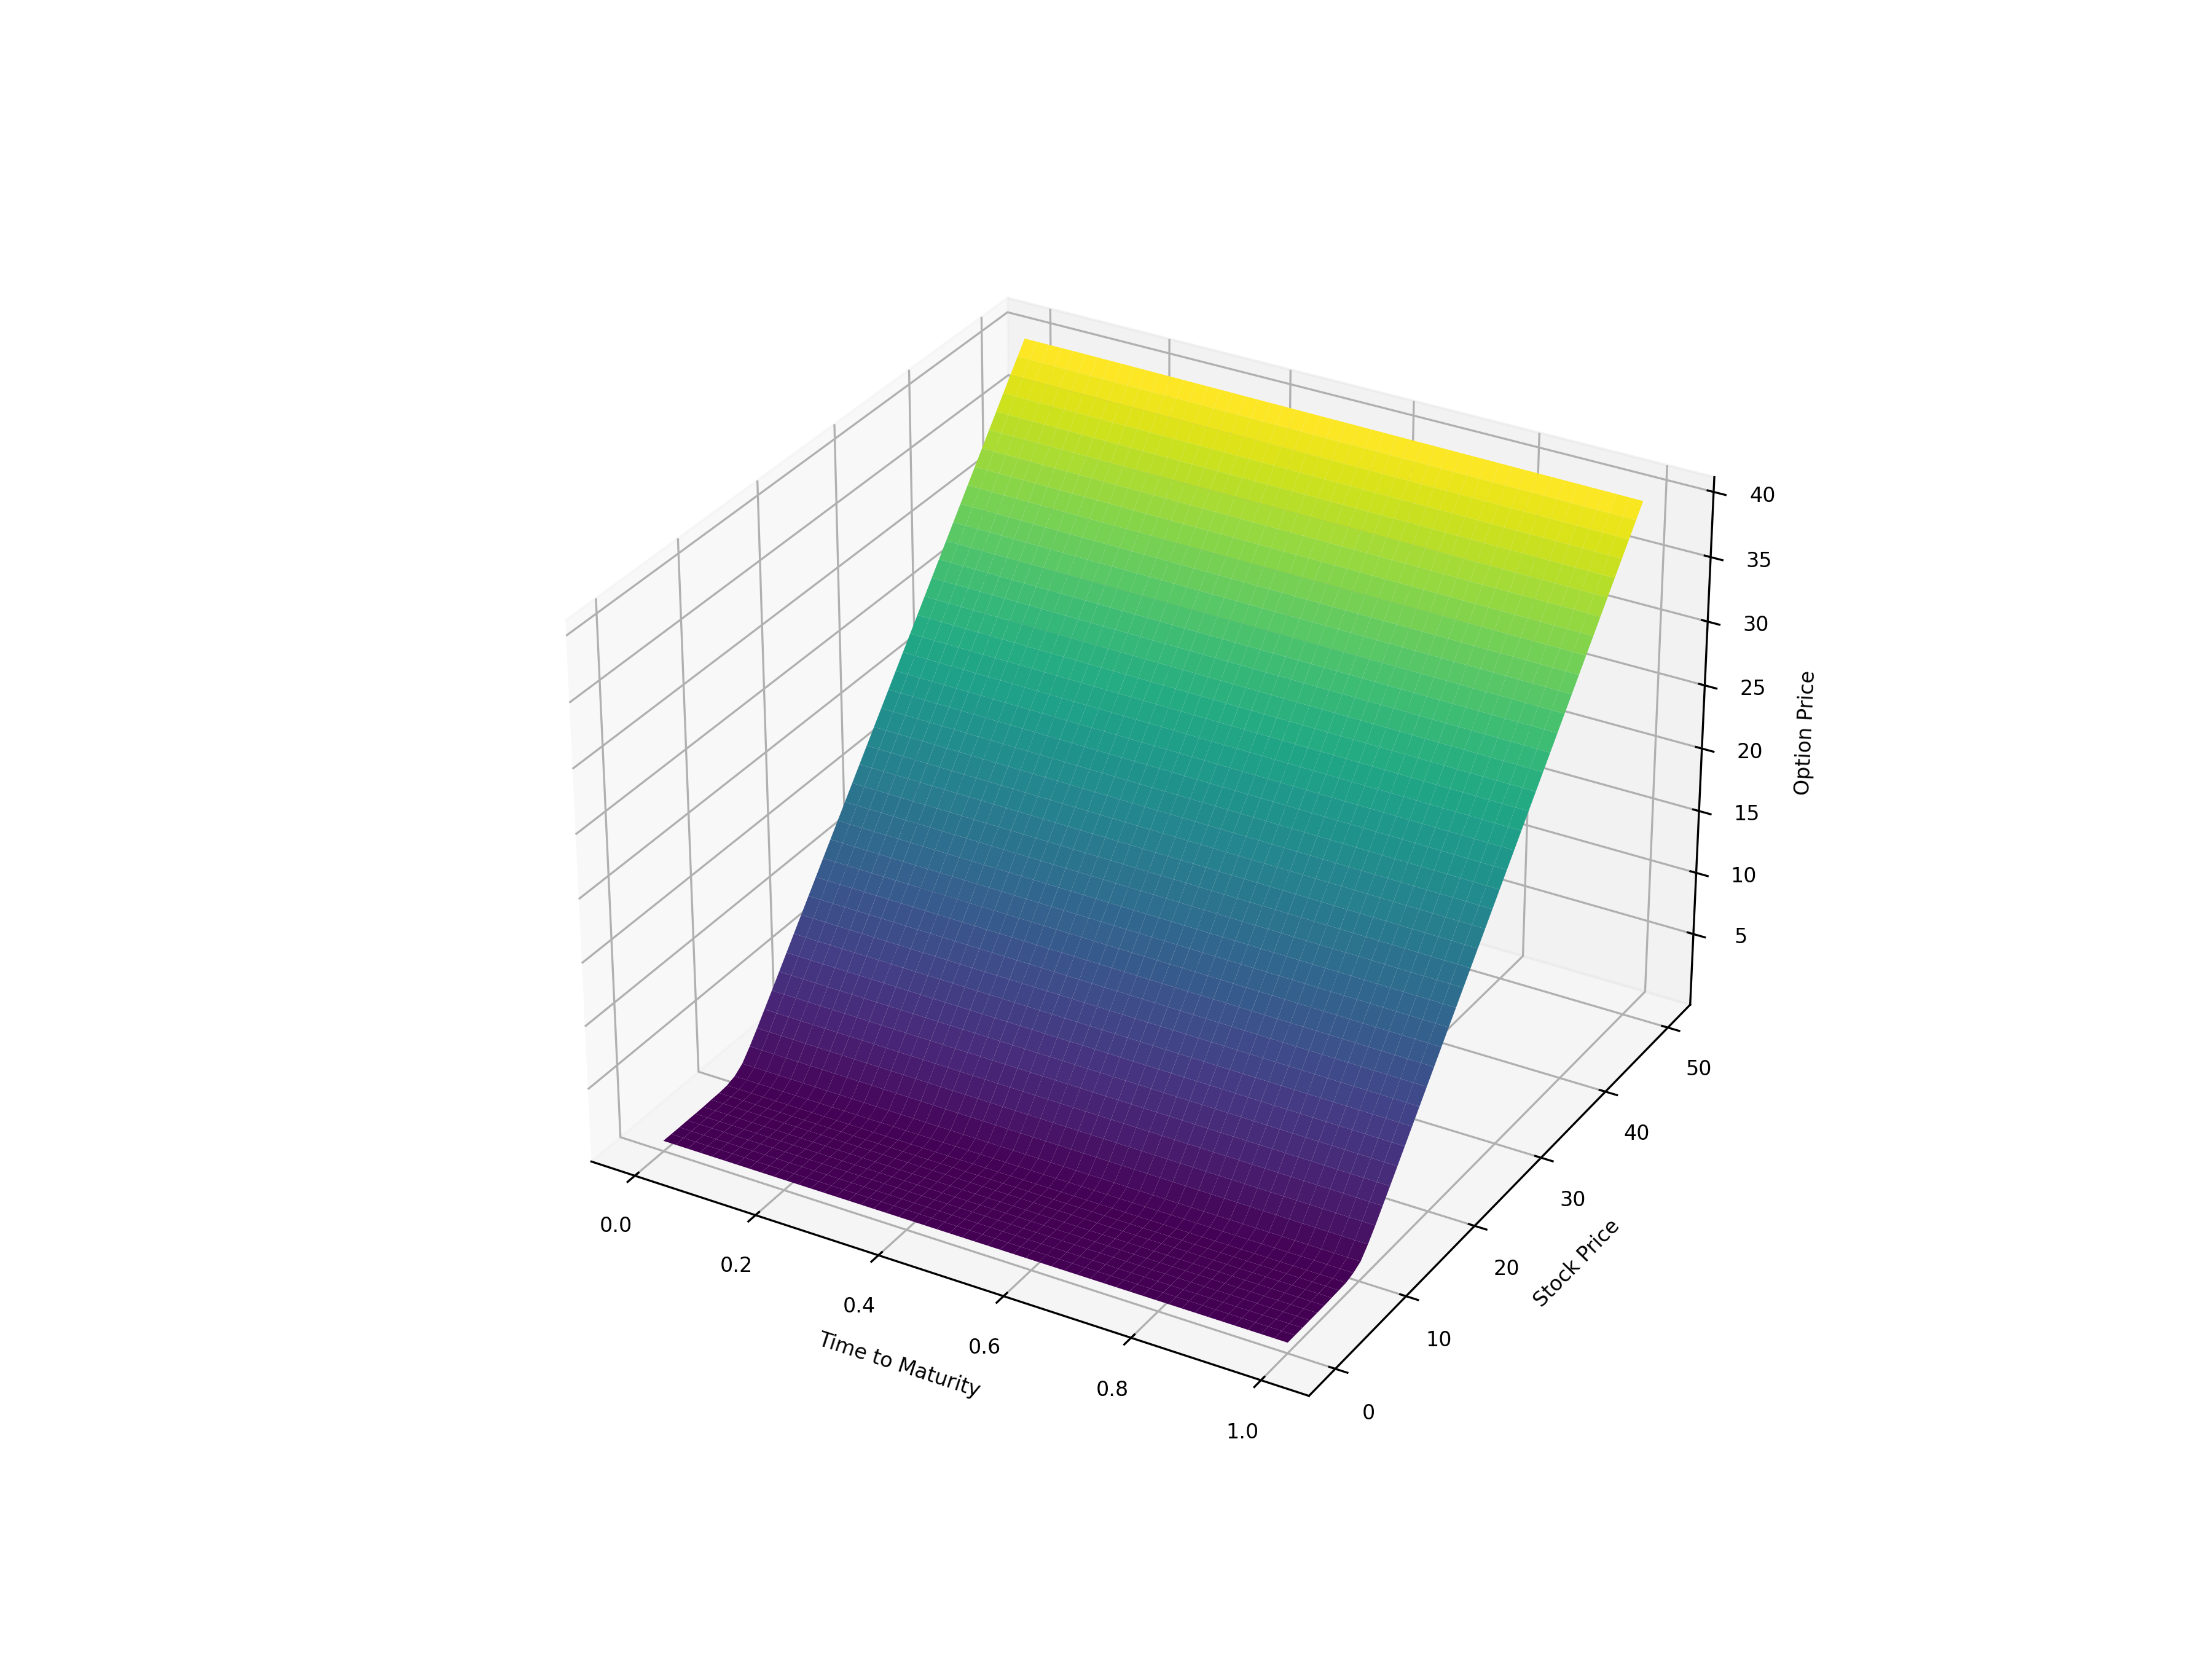

In [28]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
# Create a 3D plot using Axes3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(time_grid, stock_grid, option_prices, cmap='viridis')
ax.set_ylabel('Stock Price')
ax.set_xlabel('Time to Maturity')
ax.set_zlabel('Option Price')
# ax.set_aspect('auto')  # 'auto' preserves the aspect ratio
plt.show()